# <center> Практика. Статистические тесты в контексте EDA

## Постановка задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

### Перечень вопросов, требующих анализ:
- Какие факторы влияют на зарплату специалиста Data Scientist.

А также ответить на ключевые вопросы HR-агентства:
- Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
- Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
- Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
- Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?
- Если вы найдёте в данных интересные закономерности, также отметьте их в своём анализе.


Нужно провести исследовать данные и сделать выводы по полученным результатам. Подкрепить свои рассуждения и выводы визуализациями и с помощью статистического тестирования проверьте, являются ли выводы статистически значимыми.

Продемонстрировать использование разных тестов для проверки статистической значимости сделанных выводов:

тесты для количественного признака:
- для одной выборки;
- для двух выборок;
- для нескольких выборок;
- тест для категориальных признаков.

Ответить на эти вопросы нам помогут данные.

*   *work_year* - Год, в котором была выплачена зарплата.
*   *experience_level* - Опыт работы на этой должности в течение года со следующими возможными значениями:
    * EN — Entry-level/Junior;
    * MI — Mid-level/Intermediate;
    * SE — Senior-level/Expert;
    * EX — Executive-level/Director.
*   *employment_type* - Тип трудоустройства для этой роли:
    * PT — неполный рабочий день;
    * FT — полный рабочий день;
    * CT — контракт;
    * FL — фриланс.
*   *job_title* - Роль, в которой соискатель работал в течение года.
*   *salary* - Общая выплаченная валовая сумма заработной платы.
*   *salary_currency* -	Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.
*   *salary_in_usd* - Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).
*   *employee_residence* - Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.
*   *remote_ratio* - Общий объём работы, выполняемой удалённо. Возможные значения:
    * 0 — удалённой работы нет (менее 20 %);
    * 50 — частично удалённая работа;
    * 100 — полностью удалённая работа (более 80 %).
*   *company_location* - Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
*   *company_size* - Среднее количество людей, работавших в компании в течение года:
    * S — менее 50 сотрудников (небольшая компания);
    * M — от 50 до 250 сотрудников (средняя компания);
    * L — более 250 сотрудников (крупная компания).


[Источник датасета hr-агентства](https://lms.skillfactory.ru/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block@ds_salaries.zip)

## Загрузка данных

In [3]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns
import re

# делаем визуальную настройку графиковsns.set_theme("notebook") 
sns.set_palette("Set2") 

Данные были скопированы в Google Drive, они доступны по [ссылке](https://drive.google.com/file/d/1b_NEk_nrBLhYxBo-DI-TVLRsTIOYvk-r/view).

Для скачивания данных используйте команду `!wget`.

Данные появятся в локальной директории.

In [ ]:
# скачиваем датасет 

# в ссылке указан id файла на Google Drive "1b_NEk_nrBLhYxBo-DI-TVLRsTIOYvk-r", id файла взят из ссылки на файл https://drive.google.com/file/d/1b_NEk_nrBLhYxBo-DI-TVLRsTIOYvk-r/view
!wget "https://drive.google.com/uc?export=download&id=1b_NEk_nrBLhYxBo-DI-TVLRsTIOYvk-r" -O insurance.csv


Для windows систем можно скачать этим скриптом в папку data/

In [ ]:
import requests
import zipfile
import os

# Класс для обработки пользовательских искдлючений
class UserException (ValueError):
    def __init__(self, message):
        super().__init__(message)
        self.msg = message

# Папка для данных
path = './data/' 
# Файл архива с данными
fname_zip = 'ds_salaries.zip'
# Полный путь к архиву
full_fname_zip = path + fname_zip
# Полный путь к файлу с данными
full_fname_csv = path + fname_zip.replace( '.zip', '.csv' )

# URL для ссылки на данные
url = 'https://lms.skillfactory.ru/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block@ds_salaries.zip'

try:
    # Читаем файл по адресу url и помещаем в бинарном виде в full_fname
    response = requests.get(url)
    with open( full_fname_zip, 'wb' ) as file:
	    file.write( response.content )
     
    # Проверим наличие архива
    if not os.path.exists( full_fname_zip ): 
        raise UserException( f'Не удалось скачать файл {fname_zip} с ресурса {url}' )
    
    # Распаковываем его
    with zipfile.ZipFile( full_fname_zip, 'r') as zip_ref:
        zip_ref.extractall( path = path )

    # Проверим наличие csv
    if not os.path.exists( full_fname_csv ): 
        raise UserException( f'Файл {full_fname_csv} не найден ' )
    
    # Удаляем архив
    os.remove( full_fname_zip )
    
except UserException as ex:
    print( ex.msg )
    
except Exception as e:
    raise

else:
    response.close()

In [4]:
# загружаем датасет
data = pd.read_csv('./data/ds_salaries.csv')
data.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [5]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


## Описательный анализ данных

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


В датасете 607 записей (без пропущенных значений).

Проверим данные на наличие полных дубликатов:

In [8]:
# Удалим колонку с номером строки
data.drop( 'Unnamed: 0', axis = 1, inplace = True );

print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

# Удаляем дубликаты:
data.drop_duplicates(inplace=True)
print('Размер таблицы после удаления дубликатов: {}'.format(data.shape))

Количество дубликатов: 42
Размер таблицы после удаления дубликатов: (565, 11)


In [9]:
# Пропусков нет
data.isnull().mean()

work_year             0.0
experience_level      0.0
employment_type       0.0
job_title             0.0
salary                0.0
salary_currency       0.0
salary_in_usd         0.0
employee_residence    0.0
remote_ratio          0.0
company_location      0.0
company_size          0.0
dtype: float64

Анализируем информативность признаков

In [ ]:
 # Список неинформативных признаков
 # Возвращает список признаков с минимальной информацией
 # Вход: Набор данных 
def TestInrorm( data ):
    low_information_cols = [] 
    level = 0.95

    #цикл по всем столбцам
    for col in data.columns:
        #наибольшая относительная частота в признаке
        top_freq = data[col].value_counts(normalize=True).max()
        #доля уникальных значений от размера признака
        nunique_ratio = data[col].nunique() / data[col].count()
        # сравниваем наибольшую частоту с порогом
        if (top_freq >= level) | (nunique_ratio >= level):
            low_information_cols.append(col)
    return low_information_cols
        
print( TestInrorm( data  ) )
print(data[data['employment_type'] != "FT"])

['employment_type']
     work_year experience_level employment_type  \
28        2020               EN              CT   
45        2020               EN              PT   
54        2020               SE              FL   
62        2020               EN              PT   
77        2021               MI              PT   
78        2021               MI              CT   
96        2021               EN              PT   
113       2021               EN              PT   
124       2021               EN              PT   
184       2021               MI              FL   
208       2021               MI              FL   
216       2021               EN              PT   
225       2021               EX              CT   
282       2021               MI              PT   
283       2021               SE              CT   
462       2022               MI              PT   
487       2022               EN              PT   
488       2022               MI              FL   
489       2

Признак оставим, хоть и имеет подавляющее значение FT. Аномалии несут большой смысл, терять нельзя

Проверим на вабросы по методу 3х сигм. Сделаем послабление - 5 сигм (не все же распределения обязаны быть нормальными).

In [54]:
# Сделаем послабление - 5 сигм (не все же распределения обязаны быть нормальными).
# Примем решение - оставить или убрать выбросы
def outliers_z_score_mod(data, feature, log_scale=False, left = 3, right = 3):
    if isinstance(data, str):  # Проверка, если передан путь к файлу
        data = pd.read_csv(data)
                
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
        
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    
    return outliers, cleaned

outliers, cleaned = outliers_z_score_mod( data, 'salary_in_usd', left = 5, right = 5)
print(outliers[['salary_in_usd','experience_level','company_size','employment_type']])


     salary_in_usd experience_level company_size employment_type
252         600000               EX            L              FT


In [ ]:
display(data.sort_values(by='salary_in_usd').tail(10))

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
482,2022,EX,FT,Data Engineer,324000,USD,324000,US,100,US,M
25,2020,EX,FT,Director of Data Science,325000,USD,325000,US,100,US,L
519,2022,SE,FT,Applied Data Scientist,380000,USD,380000,US,100,US,L
523,2022,SE,FT,Data Analytics Lead,405000,USD,405000,US,100,US,L
63,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
225,2021,EX,CT,Principal Data Scientist,416000,USD,416000,US,100,US,S
157,2021,MI,FT,Applied Machine Learning Scientist,423000,USD,423000,US,50,US,L
97,2021,MI,FT,Financial Data Analyst,450000,USD,450000,US,100,US,L
33,2020,MI,FT,Research Scientist,450000,USD,450000,US,0,US,M
252,2021,EX,FT,Principal Data Engineer,600000,USD,600000,US,100,US,L


Выброс справа оставляем - он не критичен и укладывается в закономерность (по полю experience_level, company_size, employment_type)

Определим тип признаков

In [10]:
# Соберем статистику
data.describe(include='all')

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
count,565.000000,565,565,565,5.650000e+02,565,565.000000,565,565.000000,565,565
unique,NaN,4,4,50,NaN,17,NaN,57,NaN,50,3
top,NaN,SE,FT,Data Scientist,NaN,USD,NaN,US,NaN,US,M
freq,NaN,243,546,130,NaN,359,NaN,295,NaN,318,290
mean,2021.364602,NaN,NaN,NaN,3.381160e+05,NaN,110610.343363,NaN,69.911504,NaN,NaN
std,0.698138,NaN,NaN,NaN,1.599879e+06,NaN,72280.702792,NaN,40.900666,NaN,NaN
min,2020.000000,NaN,NaN,NaN,4.000000e+03,NaN,2859.000000,NaN,0.000000,NaN,NaN
25%,2021.000000,NaN,NaN,NaN,6.700000e+04,NaN,60757.000000,NaN,50.000000,NaN,NaN
50%,2021.000000,NaN,NaN,NaN,1.109250e+05,NaN,100000.000000,NaN,100.000000,NaN,NaN
75%,2022.000000,NaN,NaN,NaN,1.650000e+05,NaN,150000.000000,NaN,100.000000,NaN,NaN


In [11]:
# И статистику уникальных признаков
data.nunique()

work_year               3
experience_level        4
employment_type         4
job_title              50
salary                272
salary_currency        17
salary_in_usd         369
employee_residence     57
remote_ratio            3
company_location       50
company_size            3
dtype: int64

In [55]:
# Отобразим количество уникальных значений и до 5 их примеров 
for col in data.columns.to_list():
    print( f"{col}: {len(data[col].unique())} уникальных значений, {data[col].unique()[:5]}\n" )


work_year: 3 уникальных значений, [2020 2021 2022]

experience_level: 4 уникальных значений, ['MI' 'SE' 'EN' 'EX']

employment_type: 4 уникальных значений, ['FT' 'CT' 'PT' 'FL']

job_title: 50 уникальных значений, ['Data Scientist' 'Machine Learning Scientist' 'Big Data Engineer'
 'Product Data Analyst' 'Machine Learning Engineer']

salary: 272 уникальных значений, [ 70000 260000  85000  20000 150000]

salary_currency: 17 уникальных значений, ['EUR' 'USD' 'GBP' 'HUF' 'INR']

salary_in_usd: 369 уникальных значений, [ 79833 260000 109024  20000 150000]

employee_residence: 57 уникальных значений, ['DE' 'JP' 'GB' 'HN' 'US']

remote_ratio: 3 уникальных значений, [  0  50 100]

company_location: 50 уникальных значений, ['DE' 'JP' 'GB' 'HN' 'US']

company_size: 3 уникальных значений, ['L' 'S' 'M']



In [57]:
# Поделим признак на интересующие нас классы: "Data Scientist", "Data Engineer", "Other"
# Не будем подбирать по синонимам (если таковые есть)
data['job_title'].value_counts().sort_index()

# Словарь
arr_words = {
    "Data Scientist": "Data Scientist",
    #"Data Science Consultant" : "Data Scientist",
    #"Data Science Manager" : "Data Scientist",
    
    "Data Engineer" : "Data Engineer",
    #"Data Engineering Manager" : "Data Engineer"
    #"ML Engineer : "Data Engineer"
}

# Преобразование по словарю
data["job_title"] = data["job_title"].apply( lambda x: arr_words.get(x, "Other"))

# Проверим на уникальность - должно быть не более 3х строк
data["job_title"].value_counts()

job_title
Other             314
Data Scientist    130
Data Engineer     121
Name: count, dtype: int64

### Признаки проанализированы. Имеем:

##### Категориальные признаки
- work_year - порядковый, уже в числовой форме (его можно в принципе отнестии и к числовым признаком)
- experience_level - порядковый
- employment_type - номинальный
- remote_ratio - порядковый (уже в числовой форме)
- company_size - порядковый
- company_location - номинальный
- salary_currency - номинальный
- employee_residence - номинальный
- job_title - номинальный (после приведения)

##### Числовые признаки
- salary
- salary_in_usd

In [58]:
# импортируем библиотеку для работы с кодировщиками
import category_encoders as ce 

### Кодируем порядковые категориальные признаки

In [59]:
# создаем объект OrdinalEncoder, col - имя столбца, mapping - словарь с описанием кодировки
ord_encoder = ce.OrdinalEncoder(mapping=[
    {
        'col': 'experience_level',
        'mapping': {'EN': 1, 'MI': 2, 'SE': 3, 'EX': 4}
    },
    {
        'col': 'company_size',
        'mapping': {'S': 1, 'M': 2, 'L': 3 }
    }
   
])

# применяем трансформацию к столбцу
data_bin = ord_encoder.fit_transform(data[['experience_level','company_size']])
data_bin.rename( columns = {"experience_level":"experience_level_1", "company_size":"company_size_1"}, inplace=True )
# добавляем результат к исходному DataFrame
data = pd.concat([data, data_bin], axis=1)

### Создадим технический числовой признак - код стран

In [60]:
# Хотя признаки и являются категориальными номинальными - закорируем из числами для временного анализа на корреляцию

# Создадим единое множество обозначений стран
countres = set( data['company_location'].unique() )
countres = countres.union( set( data['employee_residence'].unique() ) )

# Наполним справочник
dict_countres = dict()
for id, country in enumerate( countres ):
    dict_countres[country] = id

# Сооздаем признаки по общему справочнику
data['company_location_id'] = data['company_location'].apply( lambda x: dict_countres[x] )
data['employee_residence_id'] = data['employee_residence'].apply( lambda x: dict_countres[x] )

Признаки salary и salary_currency линейно связаны в рамках стран (согласно условию задачи). Можно избавиться от признака salary, т.к. salary_in_usd уже приведен к единой валюте и может сравниваться по странам. 

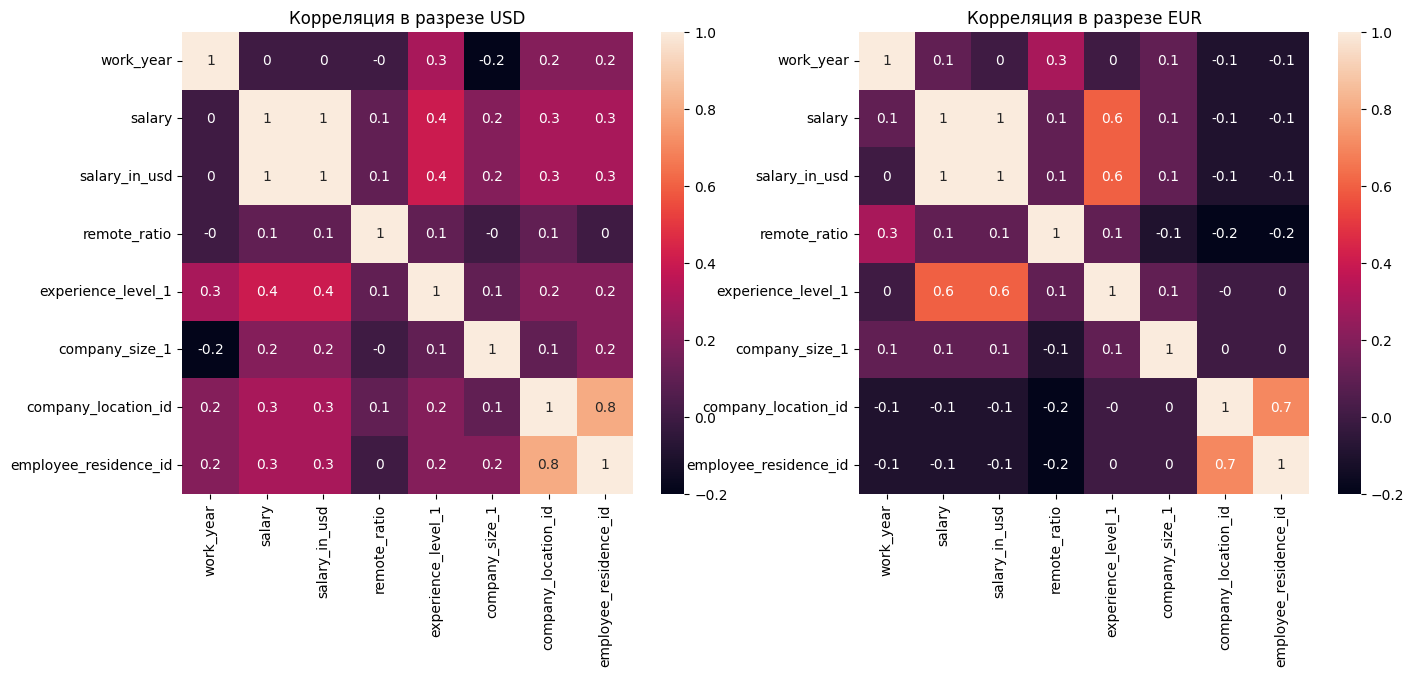

In [61]:
# На примере USD, EUR проверим корреляцию
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].set_title('Корреляция в разрезе USD')
axes[1].set_title('Корреляция в разрезе EUR')
sns.heatmap(data[data["salary_currency"] == "USD"].corr(numeric_only=True).round(1), annot=True, ax=axes[0])
sns.heatmap(data[data["salary_currency"] == "EUR"].corr(numeric_only=True).round(1), annot=True, ax=axes[1])
plt.show()

In [62]:
# И удалим коррелированные признаки. 
data.drop( ['salary','salary_currency'], axis=True, inplace=True )

Для первичного анализа корреляций построим тепловые карты и график попарных соотношений

In [ ]:
# Отображает 3 тепловых карты для визуального анализа корреляций признаков
# Вход: 
#     df - анализируемый датафрейм
#     accuracy - точность округления коэффициента корреляций
#
def heatmap_corr( df, accuracy ):
    # Для сравнения смотрим все методы
    methods = ['pearson','spearman','kendall']

    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    #Интервал
    fig.subplots_adjust(hspace = 0.3, wspace = 0.5)

    for ind, method in enumerate( methods ):
        tmp_df_corr = df.corr(numeric_only=True, method=method)
        sns.heatmap( tmp_df_corr.round(accuracy), annot=True, ax=axes[ind])
        
    plt.show()


def heatmap_corr_hr( df, accuracy ):
    heatmap_corr(df, accuracy )


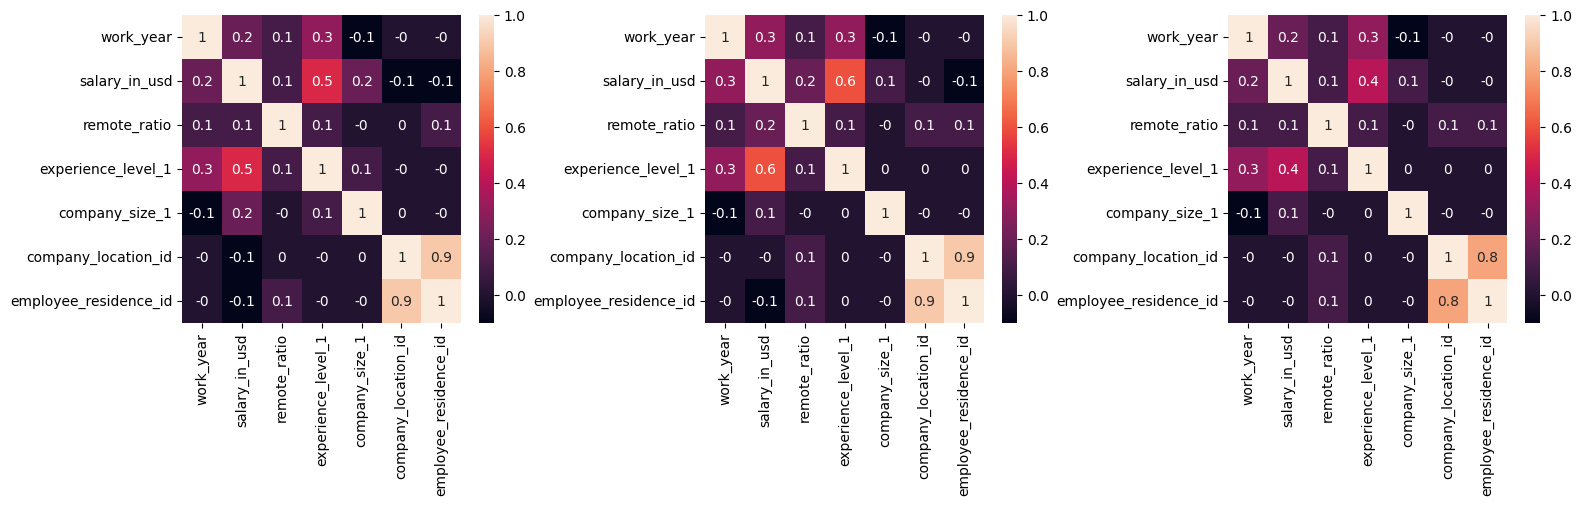

In [18]:
# Смотрим корреляцию
heatmap_corr_hr(df = data, accuracy = 1 )

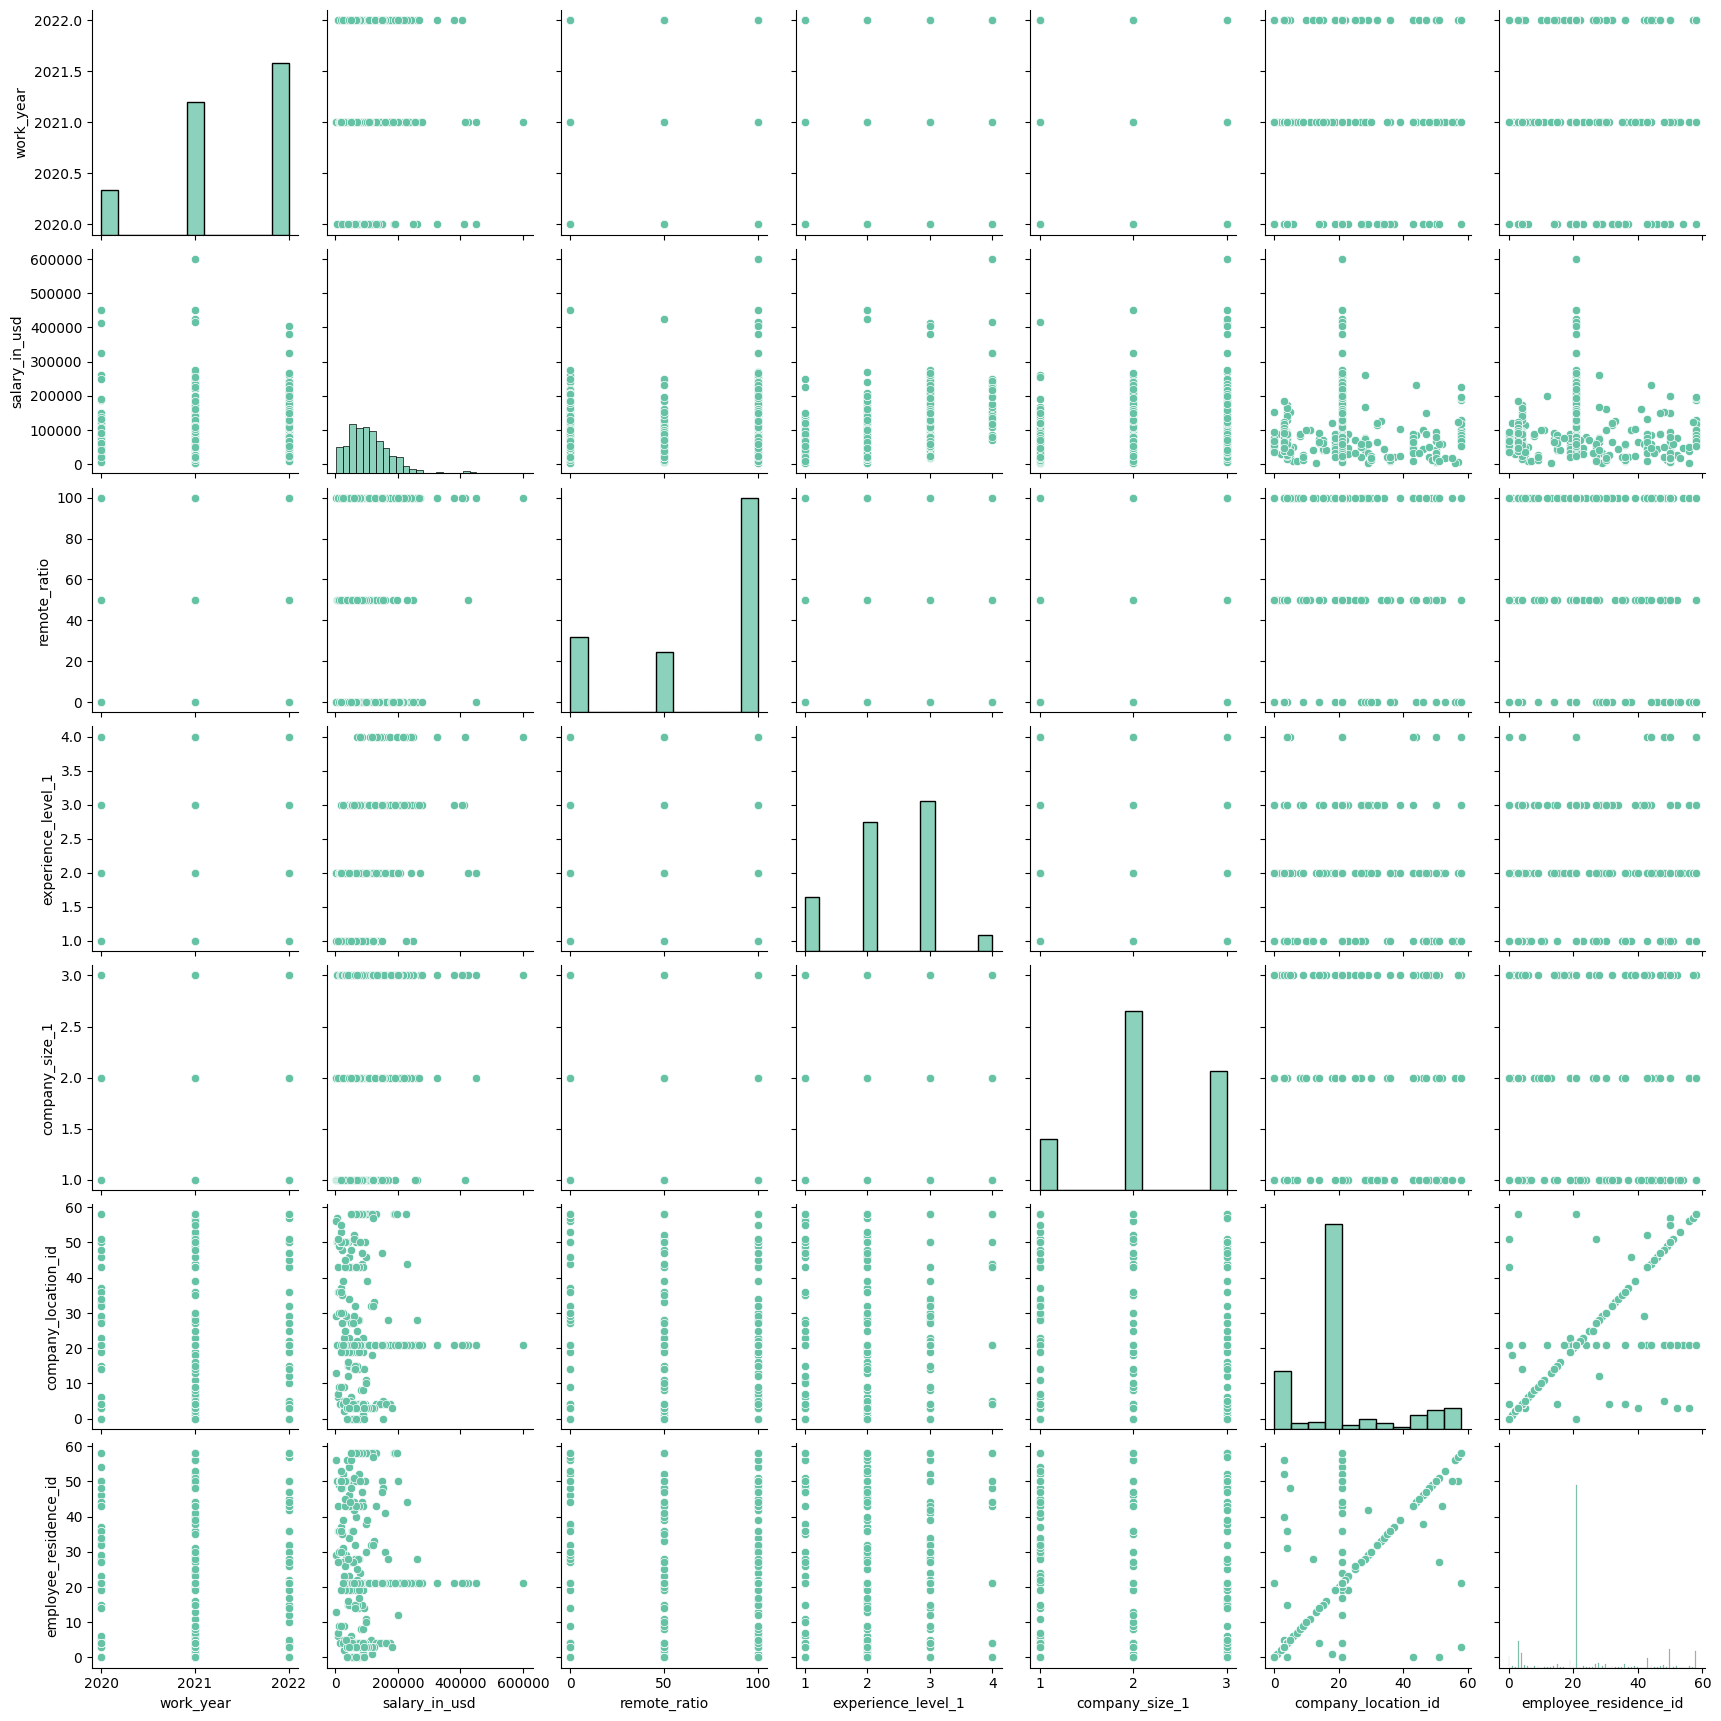

In [19]:
# И смотрим попарно корреляции признаков
sns.pairplot(data)

Видна корреляция (помним - я не удалял сами призняки, добавил лишь их числовые эквиваленты)

- *(employee_residence,company_location)* ==> Очень сильная связь, большая доля прямой связи (что логично - специалист трудится в своей стране обычно)

- *(salary_in_usd,experience_level)* ==> Средняя связь
- *(salary_in_usd,work_year)* ==> Очень слабая связь
- *(salary_in_usd,employee_residence)* ==> Очень слабая связь
- *(salary_in_usd,company_location)* ==> Очень слабая связь
- *(salary_in_usd,remote_ratio)* ==> Очень слабая связь
- *(salary_in_usd,company_size)* ==> Очень слабая связь

#### Исследуем распределение выплат на нормальность

In [20]:
data_agg = data['salary_in_usd'].describe().round(2).to_frame()
data_agg.columns = ['Статистика выплат']
data_agg
# Медиана не сошлась со средним

,Статистика выплат
count,565.00
mean,110610.34
std,72280.70
min,2859.00
25%,60757.00
50%,100000.00
75%,150000.00
max,600000.00


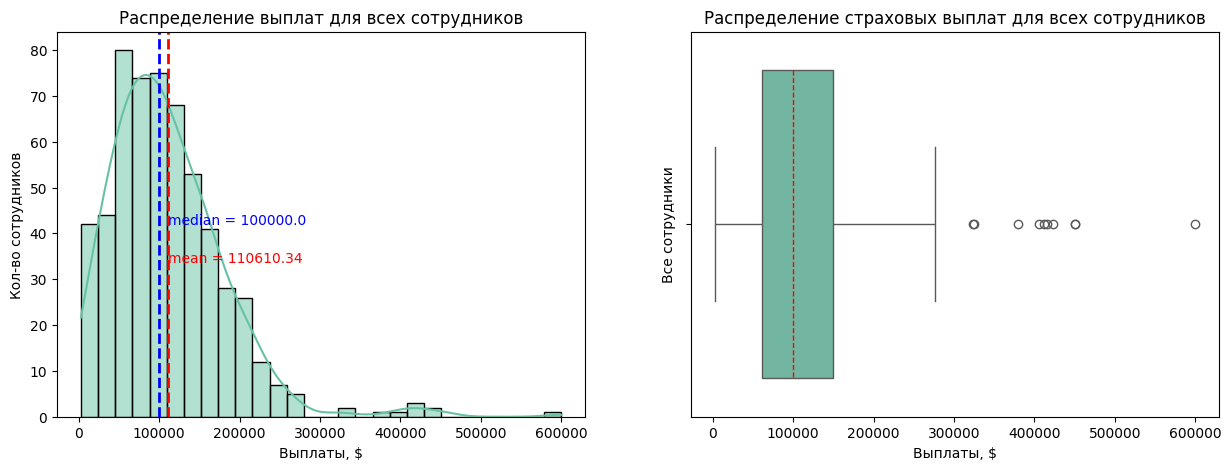

In [21]:
# визуализация систем координат 
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Датасеты для гистограммы и коробчатой диаграммы
salary_min = data['salary_in_usd'].mean().round(2)
salary_median = data['salary_in_usd'].median().round(2)

# Дабавляем гистограмму
sns.histplot(data['salary_in_usd'], kde=True, ax=axes[0])
# Подписываем оси и название графика
axes[0].set(xlabel='Выплаты, $', ylabel='Кол-во сотрудников')
axes[0].set_title('Распределение выплат для всех сотрудников')
# Нарисуем и подпишем 2 вертикальные линии - медиану и среднее
axes[0].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=2)
axes[0].axvline(data['salary_in_usd'].median(), color='blue', linestyle='--', linewidth=2)
axes[0].text(data['salary_in_usd'].mean(), 0.4, f'mean = {salary_min}', color='red', transform=axes[0].get_xaxis_transform(),
            ha='left')
axes[0].text(data['salary_in_usd'].mean(), 0.5, f'median = {salary_median}', color='blue', transform=axes[0].get_xaxis_transform(),
            ha='left')

# Дабавляем коробчатую диаграмму
sns.boxplot(data['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
# Подписываем оси и название графика
axes[1].set(ylabel='Все сотрудники', xlabel='Выплаты, $')
axes[1].set_title('Распределение страховых выплат для всех сотрудников')

# Отображаем
plt.show()


##### Распределение выплат отлично от нормального, имеются выбросы.

In [22]:
# Для дальнейшего анализа сразу выделим интересующие нас наборы данных. 
job_tst = ['Data Scientist','Data Engineer']

# Общий по 'Data Scientist','Data Engineer'
df = data[data['job_title'].isin( job_tst )].copy()
# И по отдельности
df_ds = data[(data['job_title'] == 'Data Scientist')].copy()
df_de = data[data['job_title'] == 'Data Engineer'].copy()

In [23]:
####################################################
#
# Для печати статистики в удобной форме после графиков: сообщение и таблица статистики датафрейма
# Вход: 
#    df - Датафрейм
#    col_grp - список полей, По которым идет группировка
#    col_val - Поле значения
#    msg - подпись перед таблицей
#
####################################################
def df_statistics( df, col_grp, col_val, msg ):
    data_agg = df.groupby(col_grp)[col_val].aggregate( ['count', 'mean','median', 'std', 'min', ('25%', lambda x: x.quantile(0.25)), ('75%', lambda x: x.quantile(0.75)), 'max'] ).round(2)
    print(msg)
    display( data_agg )

### 1. Ключевые вопросы HR-агентства

**1.1 Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?**

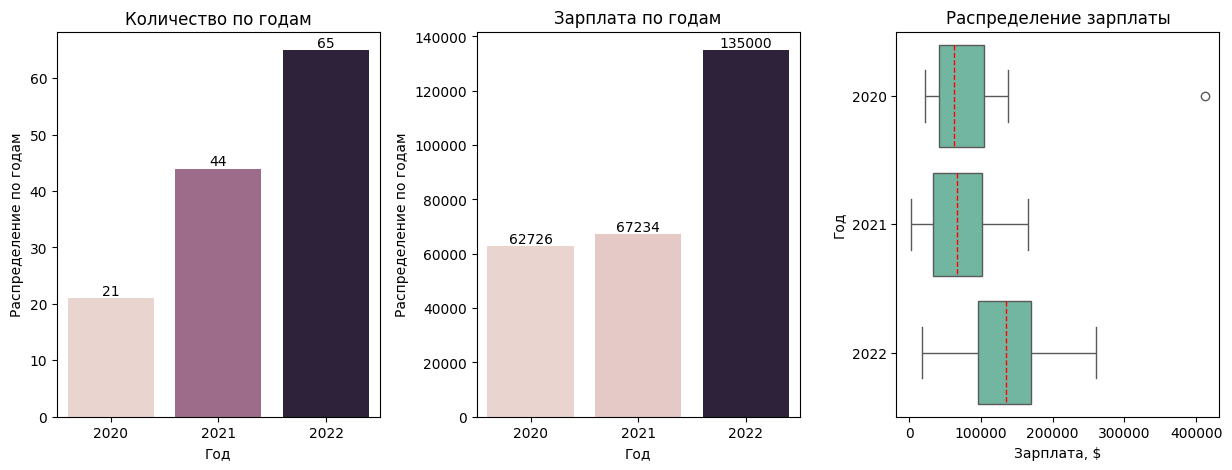

Зарплата специалиста Data Science в зависимости от года


,count,mean,median,std,min,25%,75%,max
work_year,,,,,,,,
2020,21,85970.52,62726.0,81436.65,21669,42197.00,105000.00,412000
2021,44,70215.77,67233.5,45843.82,2859,32793.75,100922.75,165000
2022,65,131366.94,135000.0,55785.24,18442,95550.00,170000.00,260000


In [24]:
# Датафреймы для графиков
df_ds_count = df_ds.groupby( ['work_year'], observed=False )['salary_in_usd'].count().to_frame()
df_ds_count.columns = ['Количество']

df_ds_median = df_ds.groupby( ['work_year'], observed=False )['salary_in_usd'].median().round(0).to_frame()
df_ds_median.columns = ['Медианная зарплата, $']

# Визуализация систем координат 
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Датафреймы для графиков
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)

# Инициализация и настройка графических объектов
sns.barplot(df_ds_count, x='work_year',y='Количество', hue='Количество', ax=axes[0], legend=False)
axes[0].set_title("Количество по годам")

sns.barplot(df_ds_median, x='work_year',y='Медианная зарплата, $', hue='Медианная зарплата, $', ax=axes[1], legend=False)
axes[1].set_title("Зарплата по годам")

sns.boxplot(df_ds, x='salary_in_usd', y='work_year', orient='h', medianprops={"color": "red", "linestyle": '--'}, ax=axes[2])
axes[2].set( ylabel="Год", xlabel="Зарплата, $")
axes[2].set_title('Распределение зарплаты')

# Подпиcь значений для столбчатых диаграмм
for ax in axes[:2]:
    ax.set(xlabel="Год", ylabel="Распределение по годам")
    for container in ax.containers:
        ax.bar_label(container)  

# Вывод на экран
plt.show()

# Численные значения
df_statistics( df_ds, 'work_year', 'salary_in_usd', 'Зарплата специалиста Data Science в зависимости от года' )

Предварительный вывод: 
- Медианные зарплаты различаются по годам
- Наблюдается рост медианной зарплаты специалистов по Data Scientist в 2022 году. 
- В 2021 и 2020 медианные зарплата примерно равны.
- В 2022 Медианная зарплата специалистов по Data Scientist в 2022 году превысила 100 тыс $.

В следующем разделе проверим статистическую значимость этих выводов

**1.2 Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?**

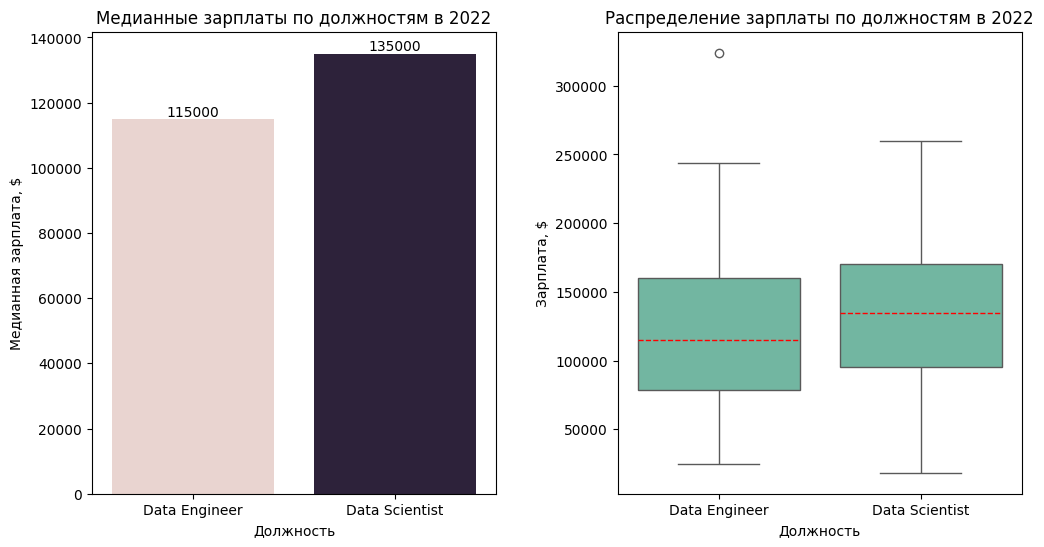

Зарплаты специалистов Data Science, Data Engeener в 2022


,count,mean,median,std,min,25%,75%,max
job_title,,,,,,,,
Data Engineer,79,124651.78,115000.0,57846.84,25000,78526.0,160040.0,324000
Data Scientist,65,131366.94,135000.0,55785.24,18442,95550.0,170000.0,260000


In [ ]:
# Датафреймы для графиков
tmp_df = df[df['work_year'] == 2022].copy()

df_ds_median = tmp_df.groupby( ['job_title'], observed=False )['salary_in_usd'].median().round(0).to_frame()
df_ds_median.columns = ['Медианная зарплата, $']

# Визуализация систем координат 
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Интервал между графиками
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)

# Инициализация и настройка bar (оси и заголовок)
sns.barplot(df_ds_median, x='job_title',y='Медианная зарплата, $', hue='Медианная зарплата, $', ax=axes[0], legend=False)
axes[0].set( xlabel="Должность")
axes[0].set_title('Медианные зарплаты по должностям в 2022')
# Подпись числовых значчений
for container in axes[0].containers:
    axes[0].bar_label(container)

# Инициализация и настройка box
sns.boxplot(tmp_df, x='job_title', y='salary_in_usd', orient='v', medianprops={"color": "red", "linestyle": '--'}, ax=axes[1])
axes[1].set( xlabel="Должность", ylabel="Зарплата, $")
axes[1].set_title('Распределение зарплаты по должностям в 2022')

# Отображаем график
plt.show()

# Численные значения
df_statistics( tmp_df, 'job_title', 'salary_in_usd', 'Зарплаты специалистов Data Science, Data Engeener в 2022' )

**Предварительный вывод:** В 2022 году медианная зарплата Data Scientist выже, чем Data Engineer

В следующем разделе проверим статистическую значимость этих выводов

**1.3 Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?**

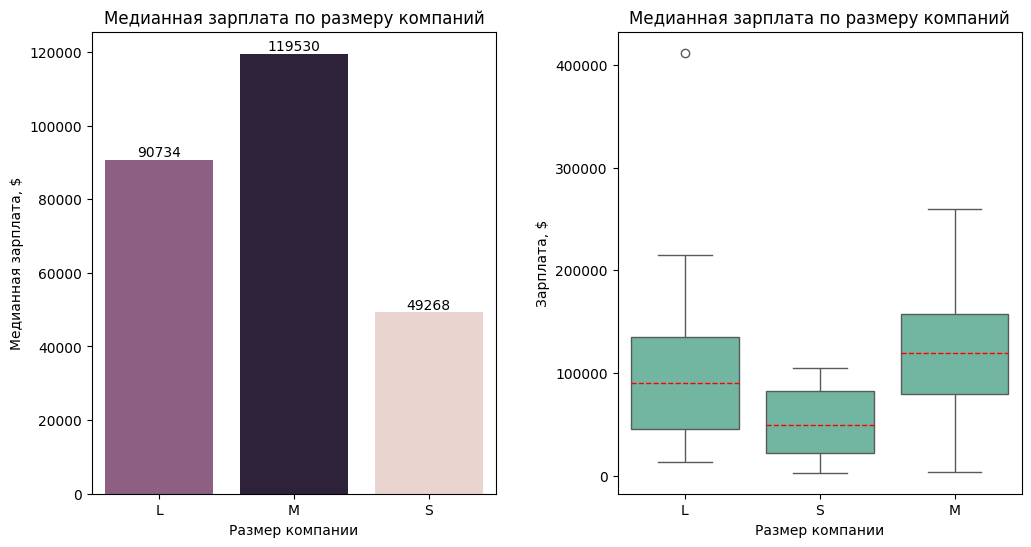

Зарплаты специалистов Data Science в разрезе размера компаний


,count,mean,median,std,min,25%,75%,max
company_size,,,,,,,,
L,43,102743.42,90734.0,73254.10,13400,45240.5,135000.0,412000
M,66,120080.58,119529.5,56347.79,4000,80000.0,157500.0,260000
S,21,51925.76,49268.0,33216.29,2859,21669.0,82500.0,105000


In [27]:
# Инициализация и настройка box
df_ds_median = df_ds.groupby( ['company_size'], observed=False )['salary_in_usd'].median().round(0).to_frame()
df_ds_median.columns = ['Медианная зарплата, $']

# Визуализация систем координат 
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Визуализация систем координат 
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)

# Визуализация систем координат 
sns.barplot(df_ds_median, x='company_size',y='Медианная зарплата, $', hue='Медианная зарплата, $', ax=axes[0], legend=False)
axes[0].set( xlabel="Размер компании")
axes[0].set_title('Медианная зарплата по размеру компаний')
for container in axes[0].containers:
    axes[0].bar_label(container)

# Инициализация и настройка bar (оси и заголовок)
sns.boxplot(df_ds, x='company_size', y='salary_in_usd', orient='v', medianprops={"color": "red", "linestyle": '--'}, ax=axes[1])
axes[1].set( xlabel="Размер компании", ylabel="Зарплата, $")
axes[1].set_title('Медианная зарплата по размеру компаний')

# Визуализация систем координат 
plt.show()

# Численные значения
df_statistics( df_ds, 'company_size', 'salary_in_usd', 'Зарплаты специалистов Data Science в разрезе размера компаний' )


**Предварительный вывод:**
- Медианные зарплаты зависят от размера компании
- В малых компаниях специалисты Data Scientist зарабатывают меньше
- В средних компаниях медианная зарплата специалистов Data Scientist выше, чем в крупных

В следующем разделе проверим статистическую значимость этих выводов

**1.4. Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании**?

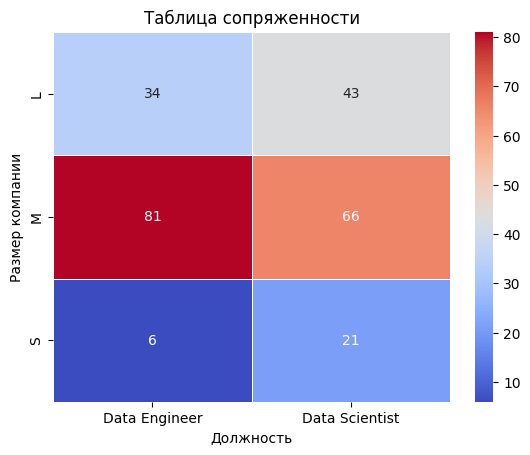

In [53]:
# Подготовка сводной таблицы
cross_tab = pd.crosstab(index=df['company_size'], columns=data['job_title'])
# Инициализация и настройка тепловой карты
ax = sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm")
ax.set(xlabel='Должность', ylabel='Размер компании')
plt.title('Таблица сопряженности')
# Инициализация и настройка тепловой карты
plt.show()

**Предварительный вывод:** Связь между наличием должностей Data Scientist и Data Engineer и размером компании имеется

В следующем разделе проверим статистическую значимость этих выводов

### 2. Выясним, какие факторы влияют на зарплату специалиста Data Scientist.

2.1 Исследуем зависимость (без проверки на статистическую достоверность) медианной зарплаты от страны проживания (топ 10 и РФ в списке) в 2022 году

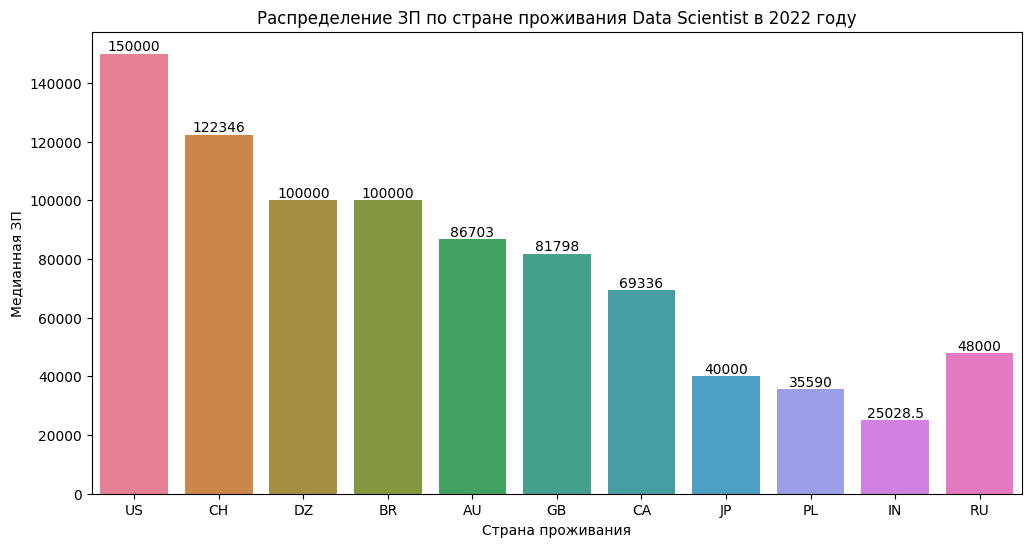

Топ 10 медианных зарплат специалистов Data Science по странам


,count,mean,median,std,min,25%,75%,max
employee_residence,,,,,,,,
AU,1,86703.0,86703.0,NaN,86703.0,86703.0,86703.0,86703.0
BR,1,100000.0,100000.0,NaN,100000.0,100000.0,100000.0,100000.0
CA,1,69336.0,69336.0,NaN,69336.0,69336.0,69336.0,69336.0
CH,1,122346.0,122346.0,NaN,122346.0,122346.0,122346.0,122346.0
DZ,1,100000.0,100000.0,NaN,100000.0,100000.0,100000.0,100000.0
GB,1,81798.0,81798.0,NaN,81798.0,81798.0,81798.0,81798.0
IN,1,25028.5,25028.5,NaN,25028.5,25028.5,25028.5,25028.5
JP,1,40000.0,40000.0,NaN,40000.0,40000.0,40000.0,40000.0
PL,1,35590.0,35590.0,NaN,35590.0,35590.0,35590.0,35590.0


In [28]:
# Покажем Топ 10 стран не РФ
df_ds_median = df_ds[(df_ds['employee_residence'] != 'RU') & (df_ds['work_year'] == 2022)].groupby( 'employee_residence' )['salary_in_usd'].median().to_frame().sort_values( by = 'salary_in_usd' ).nlargest(10, 'salary_in_usd')
# Покажем РФ в этом ряду
df_ds_median_ru = df_ds[(df_ds['employee_residence'] == 'RU') & (df_ds['work_year'] == 2022)].groupby( 'employee_residence' )['salary_in_usd'].median().to_frame()
# Склеим датасеты
df_ds_median = pd.concat( [df_ds_median,df_ds_median_ru], axis = 0 )

# Визуализация систем координат 
fig, axes = plt.subplots(1, 1, figsize=(12, 6))
# Инициализация и настройка bar
ax = sns.barplot(data=df_ds_median, x='employee_residence', y='salary_in_usd', hue='employee_residence' )
ax.set(xlabel='Страна проживания', ylabel='Медианная ЗП')
ax.set_title('Распределение ЗП по стране проживания Data Scientist в 2022 году')

# Подпись значений на bar
for container in ax.containers:
    ax.bar_label(container)

# Вывод на экран  
plt.show()

# Численные значения
df_statistics( df_ds_median, 'employee_residence', 'salary_in_usd', 'Топ 10 медианных зарплат специалистов Data Science по странам' )

**Вывод:**

- Пока США лидируют по заработной плате специалисты Data Science

**2.2 Изучим взаимосвязь признаков (без проверки на статистическую достоверность) доли работы, сделанной удаленно и опыта за 2022 в натуральном и медианно-денежном выражении**

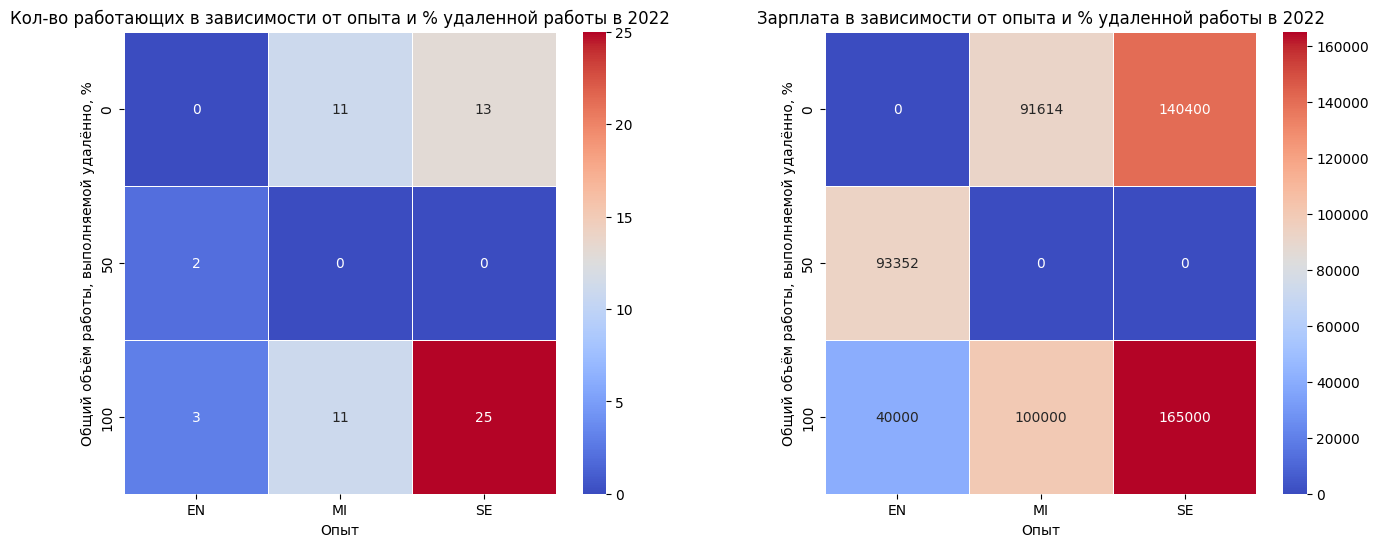

In [ ]:
# Вывод на экран
tmp_df = df_ds[ df_ds['work_year'] == 2022].copy()

# Сводные таблицы для тепловых карт
cross_tab_count = pd.crosstab(index=tmp_df['remote_ratio'], columns=tmp_df['experience_level'])
cross_tab_median = tmp_df.pivot_table(index='remote_ratio', columns='experience_level', values='salary_in_usd', aggfunc='median', fill_value=0)

# Визуализация систем координат 
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# Интервал между графиками
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)

# Инициализация и настройка heatmap (оси и заголовок) 1го графика
ax = sns.heatmap(cross_tab_count, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm", ax=axes[0])
axes[0].set(xlabel='Опыт', ylabel='Общий объём работы, выполняемой удалённо, %')
axes[0].set_title('Кол-во работающих в зависимости от опыта и % удаленной работы в 2022')

# Инициализация и настройка heatmap (оси и заголовок) 2го графика
ax = sns.heatmap(cross_tab_median, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm", ax=axes[1])
axes[1].set(xlabel='Опыт', ylabel='Общий объём работы, выполняемой удалённо, %')
axes[1].set_title('Зарплата в зависимости от опыта и % удаленной работы в 2022')

# Вывод на экран
plt.show()


**Вывод:** 
- Связь % работы на удаленке и опыта имеется. 
- Специалисты уровня MI и выше предпочитают не смешивать удаленную работу с работой в офисе
- Специалисты уровня SE предпочитают удаленную работу
- Удаленная работа более высокооплачиваема


**2.3 Изучим взаимосвязь признаков (без проверки на статистическую достоверность) доли работы, сделанной удаленно и размером компании за 2022 в натуральном и медианно-денежном выражении**

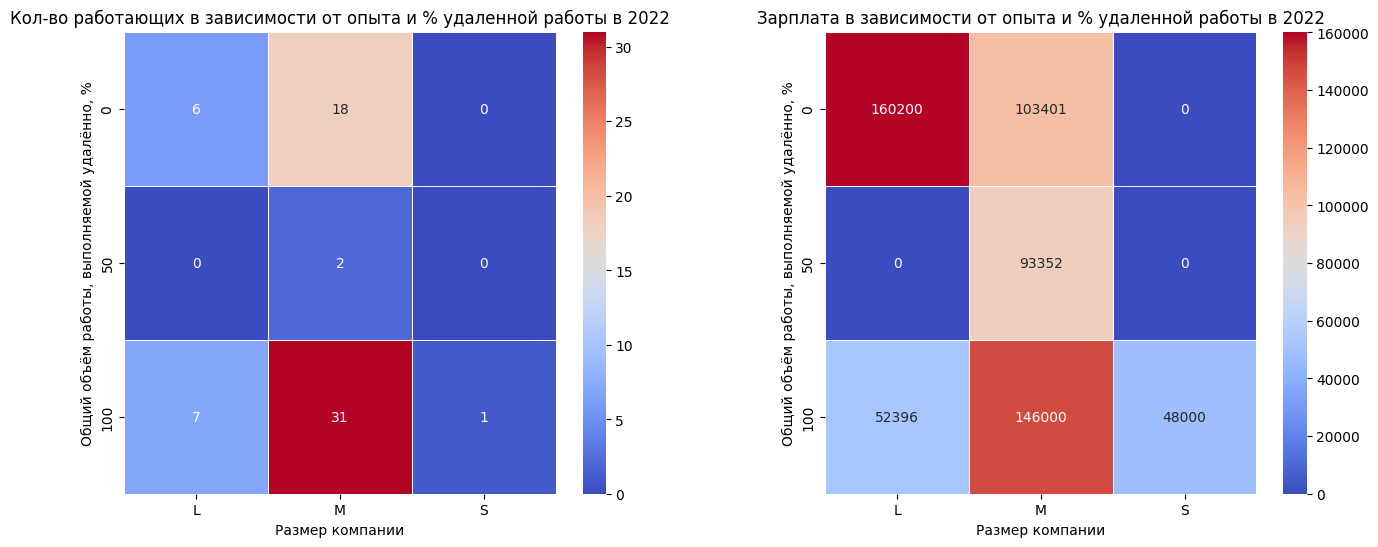

In [30]:
# Датафреймы для графиков
tmp_df = df_ds[ df_ds['work_year'] == 2022].copy()

# Сводные таблицы для тепловых карт
cross_tab_count = pd.crosstab(index=tmp_df['remote_ratio'], columns=tmp_df['company_size'])
cross_tab_median = tmp_df.pivot_table(index='remote_ratio', columns='company_size', values='salary_in_usd', aggfunc='median', fill_value=0)

# Визуализация систем координат 
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# Интервал между графиками
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)

# Инициализация и настройка heatmap (оси и заголовок) 1го графика
ax = sns.heatmap(cross_tab_count, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm", ax=axes[0])
axes[0].set(xlabel='Размер компании', ylabel='Общий объём работы, выполняемой удалённо, %')
axes[0].set_title('Кол-во работающих в зависимости от опыта и % удаленной работы в 2022')

# Инициализация и настройка heatmap (оси и заголовок) 2го графика
ax = sns.heatmap(cross_tab_median, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm", ax=axes[1])
axes[1].set(xlabel='Размер компании', ylabel='Общий объём работы, выполняемой удалённо, %')
axes[1].set_title('Зарплата в зависимости от опыта и % удаленной работы в 2022')

# Вывод на экран
plt.show()

**Вывод:**

- Смешанный режим работы не пользуется популярнростью
- В компаниях большого размера медианная зарплата выше на работе в офисе
- В компаниях среднего размера медианная зарплата выше на удаленной работе

**2.4 Изучим взаимосвязь признаков (без проверки на статистическую достоверность) размера компании и опыта за 2022 в натуральном и медианно-денежном выражении**

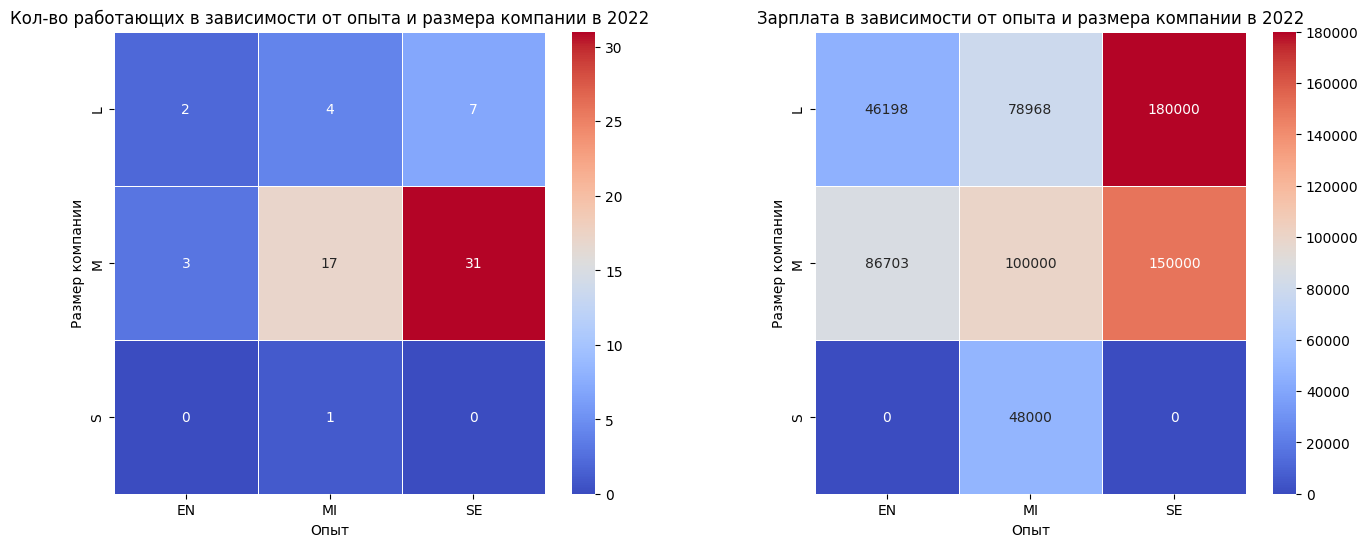

In [31]:
# Датафреймы для графиков
tmp_df = df_ds[ df_ds['work_year'] == 2022].copy()

# Сводные таблицы для тепловых карт
cross_tab_count = pd.crosstab(index=tmp_df['company_size'], columns=tmp_df['experience_level'])
cross_tab_median = tmp_df.pivot_table(index='company_size', columns='experience_level', values='salary_in_usd', aggfunc='median', fill_value=0)

# Визуализация систем координат 
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# Интервал между графиками
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)

# Инициализация и настройка heatmap (оси и заголовок) 1го графика
ax = sns.heatmap(cross_tab_count, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm", ax=axes[0])
axes[0].set(xlabel='Опыт', ylabel='Размер компании')
axes[0].set_title('Кол-во работающих в зависимости от опыта и размера компании в 2022')

# Инициализация и настройка heatmap (оси и заголовок) 2го графика
ax = sns.heatmap(cross_tab_median, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm", ax=axes[1])
axes[1].set(xlabel='Опыт', ylabel='Размер компании')
axes[1].set_title('Зарплата в зависимости от опыта и размера компании в 2022')

# Вывод на экран
plt.show()

**Вывод:** 

- Наибольший спрос сотрудников Data Science в 2022 году наблюдался в средних по размеру компаниях, наименьший - в малых
- С ростов опыта ожидаемо растем медианная зарплата

## Предварительные выводы
1. Медианные зарплаты специалистов Data Scientist различаются по годам
-   1.1 Медианные зарплаты различаются по годам
-   1.2 Наблюдается рост медианной зарплаты специалистов по Data Scientist в 2022 году по сравнению с 2021. 
-   1.3  В 2021 и 2020 медианные зарплата примерно равны
-   1.4  В 2022 Медианная зарплата специалистов по Data Scientist в 2022 году превысила 100 тыс $

2. В 2022 году медианная зарплата Data Scientist выже, чем Data Engineer

3. Медианные зарплаты зависят от размера компании
- 3.1 В малых компаниях специалисты Data Scientist зарабатывают меньше
- 3.2 В средних компаниях медианная зарплата специалистов Data Scientist выше, чем в крупных 
  
4. Связь между наличием должностей Data Scientist и Data Engineer и размером компании имеется

## Статистический анализ данных


In [99]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))
        

# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
      

### 1. Зарплата специалистов по Data Scientist зависит от года

*Нулевая гипотеза* ($H_0$): размер зарплаты не зависит от года (2020 - $μ_1$, 2021 - $μ_2$, 2022 - $μ_3$).

$ H_0 : μ_1 = μ_2 = μ_3$ 

*Альтернативная гипотеза* ($H_1$): размер зарплаты зависит от года (2020 - $μ_1$, 2021 - $μ_2$, 2022 - $μ_3$).

$ H_1 : μ_1 <> μ_2 <> μ_3$

In [141]:
# Получим значения зарплат по годам для обоих вопросов
salary_2020 = df_ds.loc[df_ds['work_year']==2020, 'salary_in_usd'].copy()
salary_2021 = df_ds.loc[df_ds['work_year']==2021, 'salary_in_usd'].copy()
salary_2022 = df_ds.loc[df_ds['work_year']==2022, 'salary_in_usd'].copy()

# проводим тест Шапиро-Уилка
print('Для 2020:')
result = stats.shapiro(salary_2020)
decision_normality(result[1])

print('Для 2021:')
result = stats.shapiro(salary_2021)
decision_normality(result[1])

print('Для 2022:')
result = stats.shapiro(salary_2022)
decision_normality(result[1])

Для 2020:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для 2021:
p-value = 0.107
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для 2022:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест. Имеем:**

* Тип у признака «salary_in_usd»: количественный.
* Количество групп: 3.
* Группы: независимы.
* Признак не распределён по нормальному закону.

Применяем тест - *"критерий Краскела-Уоллиса"*

In [142]:
# проводим тест
_, p = stats.kruskal(salary_2020, salary_2021, salary_2022)

print('p-value = {:.3f}'.format(p))
decision_hypothesis(p)

p-value = 0.000
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод:** Статистически зарплаты отличаются по годам

уточним это различие
### 1.1 Наблюдается рост зарплаты специалистов по Data Scientist в 2022 году по сравнению с 2021?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплаты в 2021 ($μ_1$) не меньше, чем в 2022 ($μ_2$).

$ H_0 : μ_1 >= μ_2$

*Альтернативная гипотеза* ($H_1$): размер зарплаты в 2021 ($μ_1$) меньше, чем в 2022 ($μ_2$).

$ H_1 : μ_1 < μ_2$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Гипотеза теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [147]:
# Сразу получим значения зарплат по годам для обоих вопросов
salary_2021 = df_ds.loc[df_ds['work_year']==2021, 'salary_in_usd'].copy()
salary_2022 = df_ds.loc[df_ds['work_year']==2022, 'salary_in_usd'].copy()

# проводим тест Шапиро-Уилка
print('Для 2021:')
result = stats.shapiro(salary_2021)
decision_normality(result[1])

print('Для 2022:')
result = stats.shapiro(salary_2022)
decision_normality(result[1])


Для 2021:
p-value = 0.107
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для 2022:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест. Имеем:**

* Тип у признака «salary_in_usd»: количественный.
* Количество групп: 2.
* Группы: независимы.
* Признаки распределены по нормальному закону.

Применяем тест - *"2х выборочный t-Критерий"*

In [144]:
# проводим тест пары выборок (2021,2022) двухвыборочным t-критерием (t-test)

# проводим тест Левена на равенство дисперсий
print('Тест на равенство дисперсий')
result = stats.levene(salary_2021, salary_2022)
p = result[1]
print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')

# проводим тест на сравнение средних в группах
print('\nТест на равенство средних')
_, p = stats.ttest_ind(salary_2021, salary_2022, alternative='less', equal_var=True)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

Тест на равенство дисперсий
p-value = 0.264
Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.

Тест на равенство средних
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


**Вывод:** В 2022 наблюдается рост зарплаты по сравнению с 2021

### 1.2 В 2020 и 2021 годах зарплаты равны

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер медианных зарплат 2020 ($μ_1$) и 2021 ($μ_2$) Data Scientist равны.

$ H_0 : μ_1 = μ_2$

*Альтернативная гипотеза* ($H_1$): размер медианных зарплат 2020 ($μ_1$) и 2021 ($μ_2$) Data Scientist отличается.

$ H_1 : μ_1 <> μ_2$

In [ ]:
# Сразу получим значения зарплат по годам для обоих вопросов
salary_2020 = df_ds.loc[df_ds['work_year']==2020, 'salary_in_usd'].copy()
salary_2021 = df_ds.loc[df_ds['work_year']==2021, 'salary_in_usd'].copy()

# проводим тест Шапиро-Уилка
print('Для 2020:')
result = stats.shapiro(salary_2020)
decision_normality(result[1])

print('Для 2021:')
result = stats.shapiro(salary_2021)
decision_normality(result[1])

Для 2020:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для 2021:
p-value = 0.107
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест. Имеем:**

Имеем:
* Тип у признака «salary_in_usd»: количественный.
* Количество групп: 2.
* Группы: независимы.
* Признак не распределён по нормальному закону в 1й из групп.

Применяем тест - *U-критерий Мана-Уитни*

In [ ]:
# проводим тест пары (2021,2022) - U-Критерий Мана-Уитни 
_, p = stats.mannwhitneyu(salary_2020, salary_2021, alternative='two-sided')

print('p-value = {:.3f}'.format(p))
decision_hypothesis(p)

p-value = 0.599
p-value = 0.599
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод:** *В 2021 и 2020 годах году медианные зарплатные платы примерно равны*

уточним это различие
### 1.3 Медианная зарплата специалистов по Data Scientist в 2022 году превысила 100 тыс $

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплаты в 2022 ($μ_1$) не превысил 100 тыс $.

$ H_0 : μ_1 <= 100000

*Альтернативная гипотеза* ($H_1$): размер зарплаты в 2022 ($μ_1$) превысил 100 тыс $.

$ H_1 : μ_1 > 100000

In [ ]:
# Готовим данные
salary_2022 = df_ds.loc[df_ds['work_year']==2022, 'salary_in_usd'].copy()

# проводим тест Шапиро-Уилка
print('Для 2022:')
result = stats.shapiro(salary_2022)
decision_normality(result[1])

Для 2022:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест. Имеем:**

Имеем:
* Тип у признака «salary_in_usd»: количественный.
* Количество групп: 1.
* Признак распределён по нормальному закону.

Применяем тест - *Одновыборочный t-Критерий*

In [108]:
# проводим тест пары (2021,2022) - U-Критерий Мана-Уитни 
_, p = stats.ttest_1samp(salary_2022, popmean=100000, alternative='greater')

print('p-value = {:.3f}'.format(p))
decision_hypothesis(p)

p-value = 0.000
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод:** *В 2022 Медианная зарплата специалистов по Data Scientist в 2022 году превысила 100 тыс $*

### 2. В 2022 году зарплата Data Scientist выше, чем Data Engineer?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер в 2022 медианной зарплаты Data Scientist ($μ_1$) не выше, чем Data Engineer ($μ_2$).

$ H_0 : μ_1 <= μ_2$

*Альтернативная гипотеза* ($H_1$): размер в 2022 медианной зарплаты Data Scientist ($μ_1$) выше, чем Data Engineer ($μ_2$).

$ H_1 : μ_1 > μ_2$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Гипотеза теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [153]:
# значения зарплат по годам
salary_2022_ds = df_ds.loc[df_ds['work_year']==2022, 'salary_in_usd'].copy()
salary_2022_de = df_de.loc[df_de['work_year']==2022, 'salary_in_usd'].copy()

# проводим тест Шапиро-Уилка
print('Для 2022, Data Science:')
result = stats.shapiro(salary_2022_ds)
decision_normality(result[1])

print('Для 2022, Data Engeneer:')
result = stats.shapiro(salary_2022_de)
decision_normality(result[1])

Для 2022, Data Science:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для 2022, Data Engeneer:
p-value = 0.007
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест. Имеем:**

* Тип у признака «salary_in_usd»: количественный.
* Количество групп: 2.
* Группы: независимы.
* Признак не распределён по нормальному закону в 1й из групп.

Применяем тест - *U-критерий Мана-Уитни*

In [157]:
# проводим тест пары критерием U-критерий Мана-Уитни)
_, p = stats.mannwhitneyu(salary_2022_ds, salary_2022_de, alternative='greater')

print('p-value = {:.3f}'.format(p))
decision_hypothesis(p)

p-value = 0.160
p-value = 0.160
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод:** **Предварительный вывод о том, что в 2022 году медианная зарплата Data Scientist выше Data Engineer не подтверждается**

### 3. Размер медианной зарплаты специалистов Data Scientist зависит от размера компаний?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер медианной зарплаты Data Scientist не зависит от размера компаний (Малая - $μ_1$, Средняя - $μ_2$, Крупная - $μ_3$).

$ H_0 : μ_1 = μ_2 = μ_3$

*Альтернативная гипотеза* ($H_1$):  размер медианной зарплаты Data Scientist зависит от размера компаний (Малая - $μ_1$, Средняя - $μ_2$, Крупная - $μ_3$).

$ H_1 : μ_1 <> μ_2 <> μ_3$


In [158]:
# значения зарплат по годам
salary_ds_small = df_ds.loc[df_ds['company_size'] == 'S', 'salary_in_usd']
salary_ds_medium = df_ds.loc[df_ds['company_size'] == 'M', 'salary_in_usd']
salary_ds_large = df_ds.loc[df_ds['company_size'] == 'L', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для малых компаний:')
result = stats.shapiro(salary_ds_small)
decision_normality(result[1])

print('Для средних компаний:')
result = stats.shapiro(salary_ds_medium)
decision_normality(result[1])

print('Для больших компаний:')
result = stats.shapiro(salary_ds_large)
decision_normality(result[1])

Для малых компаний:
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для средних компаний:
p-value = 0.897
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для больших компаний:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест. Имеем:**

* Тип у признака «salary_in_usd»: количественный.
* Количество групп: 3.
* Группы: независимы.
* Признак не распределён по нормальному закону.

Применяем тест: *критерий Краскела-Уоллиса*

In [159]:
# проводим тест
_, p = stats.kruskal(salary_ds_small, salary_ds_medium, salary_ds_large)

print('p-value = {:.3f}'.format(p))
decision_hypothesis(p)

p-value = 0.000
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод:** Размер зарплаты специалистов Data Scientist зависит от размера компаний

Уточним эту зависимость

### 3.1 Размер зарплаты специалистов Data Scientist малых компаний меньше

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер медианной зарплаты Data Scientist малых компаний ($μ_1$) не меньше средних и крупных ($μ_2$).

$ H_0 : μ_1 >= μ_2

*Альтернативная гипотеза* ($H_1$):  размер медианной зарплаты Data Scientist малых компаний ($μ_1$) меньше средних и крупных ($μ_2$).

$ H_1 : μ_1 < μ_2


In [160]:
# значения зарплат по годам
salary_ds_small = df_ds.loc[df_ds['company_size'] == 'S', 'salary_in_usd']
salary_ds_medium_big = df_ds.loc[df_ds['company_size'] != 'S', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для малых компаний:')
result = stats.shapiro(salary_ds_small)
decision_normality(result[1])

print('Для средних или больших компаний:')
result = stats.shapiro(salary_ds_medium_big)
decision_normality(result[1])

Для малых компаний:
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для средних или больших компаний:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест. Имеем:**


* Тип у признака «salary_in_usd»: количественный.
* Количество групп: 2.
* Группы: независимы.
* Признак не распределён по нормальному закону в 1й из групп.

Применяем тест: *U-критерий Мана-Уитни*

In [161]:
# проводим тест пары критерием U-критерий Мана-Уитни)
_, p = stats.mannwhitneyu(salary_ds_small, salary_ds_medium_big, alternative='less')

print('p-value = {:.3f}'.format(p))
decision_hypothesis(p)

p-value = 0.000
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод:** В малых компаниях специалисты Data Scientist зарабатывают меньше, чем в более крупных компаниях

### 3.2 В средних компаниях специалисты Data Scientist зарабатывают больше, чем в крупных 

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер медианной зарплаты Data Scientist в средних ($μ_1$) в средних компаниях не больше, чем в крупных (($μ_2$).

$ H_0 : μ_1 <= μ_2$

*Альтернативная гипотеза* ($H_1$): размер медианной зарплаты Data Scientist в средних ($μ_1$) в средних компаниях больше, чем в крупных (($μ_2$).

$ H_1 : μ_1 > μ_2$

In [164]:
# значения зарплат по годам
salary_ds_medium = df_ds.loc[df_ds['company_size'] == 'M', 'salary_in_usd']
salary_ds_big = df_ds.loc[df_ds['company_size'] == 'L', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для средних компаний:')
result = stats.shapiro(salary_ds_medium)
decision_normality(result[1])

print('Для больших компаний:')
result = stats.shapiro(salary_ds_big)
decision_normality(result[1])

Для средних компаний:
p-value = 0.897
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для больших компаний:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест. Имеем:**


* Тип у признака «salary_in_usd»: количественный.
* Количество групп: 2.
* Группы: независимы.
* Признак не распределён по нормальному закону в 1й из групп.

Применяем тест: *U-критерий Мана-Уитни*

In [165]:
# проводим тест пары критерием U-критерий Мана-Уитни)
_, p = stats.mannwhitneyu(salary_ds_medium, salary_ds_big, alternative='greater')

print('p-value = {:.3f}'.format(p))
decision_hypothesis(p)

p-value = 0.024
p-value = 0.024
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод:** В средних компаниях специалисты Data Scientist зарабатывают больше, чем в крупных 

### 4. Связи между наличием должностей Data Scientist и Data Engineer и размером компании нет

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: Связи между наличием должностей Data Scientist и Data Engineer и размером компании нет (признаки независимы).

*Альтернативная гипотеза*: Связь между наличием должностей Data Scientist и Data Engineer и размером компании нет (признаки зависимы).

**Выберем подходящий статистический тест. Имеем:**

* Тип у признака «job_title»: Категориальный.
* Тип у признака «company_size»: Категориальный.
* Количество групп: 2.
* Группы: независимы.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [169]:
# составляем таблицу сопряжённости
cross_table = pd.crosstab(df['job_title'], df['company_size'])
cross_table

company_size,L,M,S
job_title,,,
Data Engineer,34,81,6
Data Scientist,43,66,21


In [170]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_table)
decision_hypothesis(p)

p-value = 0.005
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Существует статистически значимая взаимосвязь между наличием должностей Data Scientist и Data Engineer и размером компании.

## Итоговые результаты исследования

*   Зарплаты специалистов Data Scientist различаются по годам. 
    -   Наблюдается рост в 2022 году, в 2020 и 2021 зарплаты равны.
    -   В 2022 Медианная зарплата специалистов по Data Scientist в 2022 году превысила 100 тыс $.
*   Не подтверждается, что в 2022 году зарплата специалистов Data Scientist выше, чем специалистов Data Engineer.
*   Зарплаты специалистов Data Scientist зависят от размера компании. В малых компаниях зарабатывают меньше, в средних больше.
*   Связь между наличием должностей Data Scientist и Data Engineer и размером компании имеется. 

## Также по данным 2022 года по специалистам Data Scientist без статистического анализа сделаны дополнительные выводы

*   США лидируют по заработной плате.
*   Есть связь доли работ, выполненных удаленно и опыта имеется. 
    - Специалисты уровня MI и выше предпочитают не смешивать удаленную работу с работой в офисе.
    - Специалисты уровня SE предпочитают удаленную работу.
    - Удаленная работа более высокооплачиваема.
*   Смешанный режим работы (50% удаленно) не пользуется популярностью.
    - В компаниях большого размера медианная зарплата выше на работе в офисе.
    - В компаниях среднего размера медианная зарплата выше на удаленной работе.
*   Наибольший спрос сотрудников Data Science в 2022 году наблюдался в средних по размеру компаниях, наименьший - в малых.
*   С ростом опыта ожидаемо растет медианная зарплата.
